Hugo Deplagne

# Deep Q-Learning using PyTorch and OpenAI Gym to play Breakout

In [1]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from DQN_torch import DQN
from ReplayBuffer import ReplayBuffer
from create_video import create_video
from preprocess import CustomWrapper

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
env = gym.make('BreakoutNoFrameskip-v4', render_mode='rgb_array')
# Preprocess the environment (important if you want luminance to put grayscale as False)
env = CustomWrapper(env, noop_max=30, frame_skip=4, screen_size=84, luminance_obs=True, grayscale_obs=False)
# Stack 4 frames
env = gym.wrappers.FrameStack(env, 4)

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


Let's see what a state looks like:

Image shape:  (4, 84, 84)
Image type:  uint8


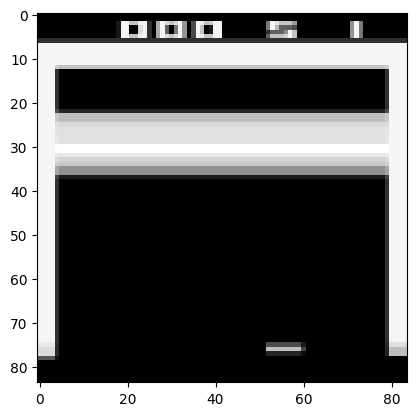

In [3]:
env.reset()
img, _, _, _, _ = env.step(0)
print('Image shape: ', img.shape)
print('Image type: ', img.dtype)

import matplotlib.pyplot as plt
plt.imshow(img[0], cmap='gray')

The state dimensions:

In [4]:
state_dim = env.observation_space.shape
num_actions = env.action_space.n

print('State shape: ', env.observation_space)
print('Number of actions: ', num_actions)

State shape:  Box(0, 255, (4, 84, 84), uint8)
Number of actions:  4


#### Now we create the model set the parameters and train the model

In [5]:
# Instantiate the Q-network model and target model
model = DQN((4,84,84), num_actions).to(device)
model_target = DQN((4,84,84), num_actions).to(device)
model_target.load_state_dict(model.state_dict())
model

DQN(
  (conv1): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
)

Model architecture same as deep mind article.  
As well as following variables.

In [6]:
# Define other parameters and hyperparameters
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.1
epsilon_max = 1.0
epsilon_interval = epsilon_max - epsilon_min
batch_size = 32
max_steps_per_episode = 10000
max_memory_length = 100000
replay_buffer = ReplayBuffer(device, max_memory_length)
optimizer = optim.Adam(model.parameters(), lr=0.00025)
loss_function = nn.HuberLoss()

episode_reward_history = np.array([])
running_reward = 0
episode_count = 0
frame_count = 0
epsilon_random_frames = 50000
epsilon_greedy_frames = 1000000.0
update_target_network = 10000

reward_history = np.array([])
frame_count_history = np.array([])
epsilon_history = np.array([])
best_reward = 0

In [7]:
while True:
    env.reset()
    state, _, done, _, _ = env.step(0)
    state = np.array(state, dtype=np.uint8)
    episode_reward = 0

    for timestep in range(1, max_steps_per_episode):
        frame_count += 1

        if frame_count < epsilon_random_frames or epsilon > np.random.rand(1):
            action = np.random.choice(num_actions)
            action = np.uint8(action)
        else:
            with torch.no_grad():
                state = np.array(state, dtype=np.uint8)
                q_values = model(torch.tensor(state).unsqueeze(0).float().to(device))
                action = torch.argmax(q_values).item()
                action = np.uint8(action)

        if epsilon > epsilon_min:
            epsilon -= epsilon_interval / epsilon_greedy_frames
            epsilon = max(epsilon, epsilon_min)

        next_state, reward, done, e, f = env.step(action)
        next_state =  np.array(next_state, dtype=np.uint8)
        episode_reward += reward

        replay_buffer.add(state, action, reward, next_state, done)
        state = next_state

        if len(replay_buffer) > batch_size:
            states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

            future_rewards = model_target(next_states).max(1)[0]
            updated_q_values = rewards + gamma * future_rewards * (1 - dones)

            current_q_values = model(states)
            selected_q_values = current_q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

            loss = loss_function(updated_q_values, selected_q_values)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # To avoid biais de sur-estimation update the target network every update_target_network steps
        if frame_count % update_target_network == 0:
            model_target.load_state_dict(model.state_dict())

        if done:
            break

    episode_reward_history = np.append(episode_reward_history, episode_reward)
    running_reward = np.mean(episode_reward_history)

    if episode_count % 10 == 0:
        if len(episode_reward_history) > 100:
            episode_reward_history = np.delete(episode_reward_history, np.s_[:10])
        running_reward = np.mean(episode_reward_history)
        print("Episode {} reward: {} frame_count: {} epsilon: {} memory size: {}".format(episode_count, running_reward, frame_count, epsilon, len(replay_buffer)))
        reward_history = np.append(reward_history, running_reward)
        frame_count_history = np.append(frame_count_history, frame_count)
        epsilon_history = np.append(epsilon_history, epsilon)

    if running_reward > 5 and running_reward > best_reward:
        best_reward = running_reward
        torch.save(model.state_dict(), f"models/model_rew_{round(running_reward)}.pth")

    if running_reward > 40:
        print("Solved at episode {}!".format(episode_count))
        break

    episode_count += 1

Episode 0 reward: 1.0 frame_count: 180 epsilon: 0.9998380000000053 memory size: 180
Episode 10 reward: 0.6363636363636364 frame_count: 1788 epsilon: 0.998390800000053 memory size: 1788
Episode 20 reward: 0.5238095238095238 frame_count: 3298 epsilon: 0.9970318000000977 memory size: 3298
Episode 30 reward: 0.6774193548387096 frame_count: 5099 epsilon: 0.9954109000001511 memory size: 5099
Episode 40 reward: 0.8292682926829268 frame_count: 6975 epsilon: 0.9937225000002067 memory size: 6975
Episode 50 reward: 1.1176470588235294 frame_count: 9195 epsilon: 0.9917245000002725 memory size: 9195
Episode 60 reward: 1.2950819672131149 frame_count: 11458 epsilon: 0.9896878000003395 memory size: 11458
Episode 70 reward: 1.3943661971830985 frame_count: 13657 epsilon: 0.9877087000004047 memory size: 13657
Episode 80 reward: 1.3209876543209877 frame_count: 15334 epsilon: 0.9861994000004544 memory size: 15334
Episode 90 reward: 1.2637362637362637 frame_count: 17070 epsilon: 0.9846370000005058 memory siz

KeyboardInterrupt: 

Lets look at the evolution of the reward over the time steps:

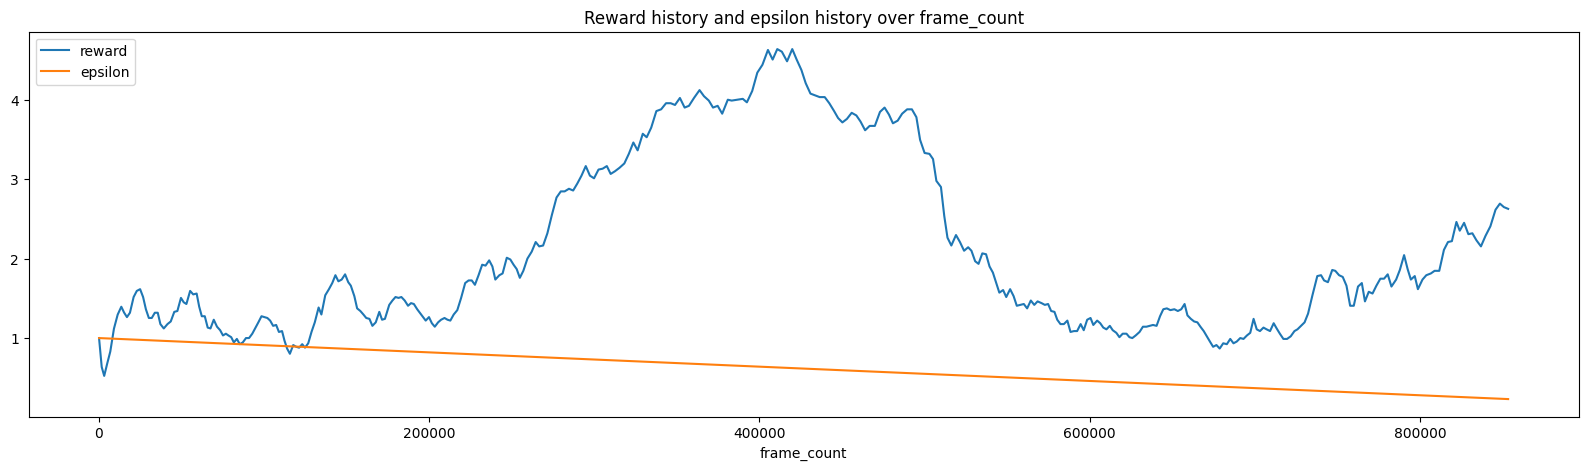

In [8]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20,5))
plt.plot(frame_count_history, reward_history)
plt.plot(frame_count_history, epsilon_history)
plt.title('Reward history and epsilon history over frame_count')
plt.xlabel('frame_count')
plt.legend(['reward', 'epsilon'], loc='upper left')
plt.show()

#### Section to save the video of the agent playing the game through the different models

In [9]:
torch.save(model.state_dict(), 'models/model_weights.pth')

In [14]:
env = gym.make('BreakoutNoFrameskip-v4', render_mode='rgb_array')
env = gym.wrappers.AtariPreprocessing(env, frame_skip=4, grayscale_obs=True, scale_obs=True, noop_max=30)
env = gym.wrappers.FrameStack(env, num_stack=4)
create_video(env, model, device, folder="videos", name="video")

Moviepy - Building video videos/video.mp4.
Moviepy - Writing video videos/video.mp4



Moviepy - Done !
Moviepy - video ready videos/video.mp4


0.0

Using best model:

In [ ]:
model = DQN((4,84,84), num_actions).to(device)
model.load_state_dict(torch.load("models/model_rew_27.pth"))

env = gym.make('BreakoutNoFrameskip-v4', render_mode='rgb_array')
env = gym.wrappers.AtariPreprocessing(env, frame_skip=4, grayscale_obs=True, scale_obs=True, noop_max=30)
env = gym.wrappers.FrameStack(env, num_stack=4)
r = create_video(env, model, device, folder="videos", name="best2")
print(f"Reward : {r}")

Moviepy - Building video videos/best2.mp4.
Moviepy - Writing video videos/best2.mp4



Moviepy - Done !
Moviepy - video ready videos/best2.mp4
Reward : 46.0
